This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introduction to deep learning for computer vision

## Introduction to convnets

**Instantiating a small convnet**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Displaying the model's summary**

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

**Training the convnet on MNIST images**

In [3]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 16s 5ms/step - loss: 0.1665 - accuracy: 0.9482
Epoch 2/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0459 - accuracy: 0.9860
Epoch 3/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0313 - accuracy: 0.9902
Epoch 4/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0231 - accuracy: 0.9927
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0182 - accuracy: 0.9944


**Evaluating the convnet**

In [4]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0218 - accuracy: 0.9929
Test accuracy: 0.993


### The convolution operation

#### Understanding border effects and padding

#### Understanding convolution strides

### The max-pooling operation

**An incorrectly structured convnet missing its max-pooling layers**

In [5]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

## Training a convnet from scratch on a small dataset

### The relevance of deep learning for small-data problems

### Downloading the data

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"edmonsahakyan","key":"3bb9ab4df24490f8509a77af0944671e"}'}

In [8]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c dogs-vs-cats

 99% 803M/812M [00:10<00:00, 103MB/s] 
100% 812M/812M [00:10<00:00, 80.5MB/s]


In [10]:
!unzip -qq dogs-vs-cats.zip

In [11]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [12]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [14]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

**Configuring the model for training**

In [15]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [16]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [17]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [18]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [19]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [20]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [21]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 9s 91ms/step - loss: 0.7018 - accuracy: 0.5075 - val_loss: 0.6914 - val_accuracy: 0.5810
Epoch 2/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6930 - accuracy: 0.5180 - val_loss: 0.6819 - val_accuracy: 0.5790
Epoch 3/30
63/63 [==============================] - 5s 76ms/step - loss: 0.6809 - accuracy: 0.5805 - val_loss: 0.6422 - val_accuracy: 0.6380
Epoch 4/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6501 - accuracy: 0.6350 - val_loss: 0.6399 - val_accuracy: 0.6540
Epoch 5/30
63/63 [==============================] - 4s 64ms/step - loss: 0.6243 - accuracy: 0.6595 - val_loss: 0.5799 - val_accuracy: 0.6930
Epoch 6/30
63/63 [==============================] - 5s 77ms/step - loss: 0.5874 - accuracy: 0.6840 - val_loss: 0.5849 - val_accuracy: 0.6890
Epoch 7/30
63/63 [==============================] - 4s 62ms/step - loss: 0.5385 - accuracy: 0.7335 - val_loss: 0.5692 - val_accuracy: 0.7060
Epoch 8/30
63

**Displaying curves of loss and accuracy during training**

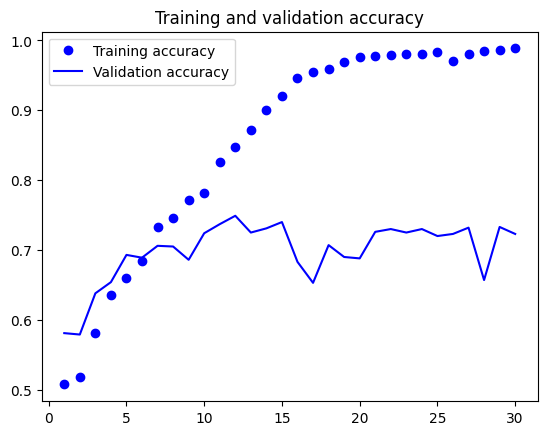

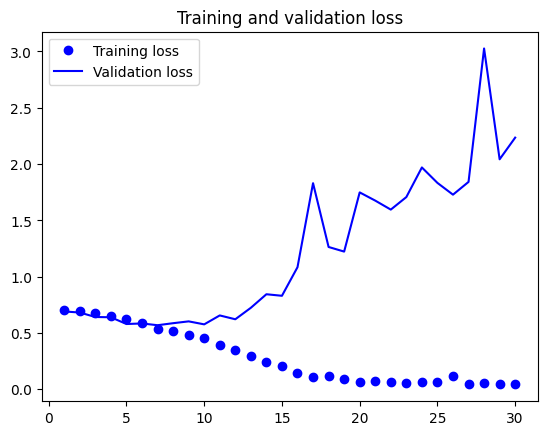

In [23]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [24]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 34ms/step - loss: 0.5803 - accuracy: 0.6785
Test accuracy: 0.678


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [25]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.GaussianNoise(0.1),
    ]
)

**Displaying some randomly augmented training images**

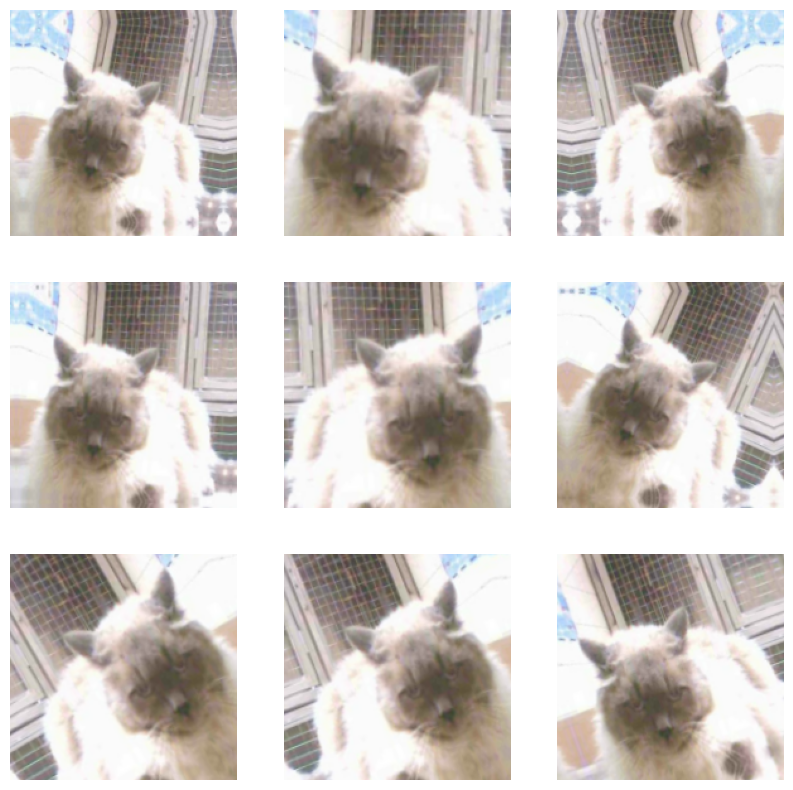

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 7s 68ms/step - loss: 0.7068 - accuracy: 0.5125 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 5s 78ms/step - loss: 0.6938 - accuracy: 0.5055 - val_loss: 0.6919 - val_accuracy: 0.5150
Epoch 3/100
63/63 [==============================] - 5s 66ms/step - loss: 0.6977 - accuracy: 0.5490 - val_loss: 0.6829 - val_accuracy: 0.5630
Epoch 4/100
63/63 [==============================] - 4s 64ms/step - loss: 0.6788 - accuracy: 0.5730 - val_loss: 0.8059 - val_accuracy: 0.5150
Epoch 5/100
63/63 [==============================] - 5s 83ms/step - loss: 0.6777 - accuracy: 0.5980 - val_loss: 0.6531 - val_accuracy: 0.6060
Epoch 6/100
63/63 [==============================] - 4s 63ms/step - loss: 0.6530 - accuracy: 0.6270 - val_loss: 0.6560 - val_accuracy: 0.5870
Epoch 7/100
63/63 [==============================] - 6s 87ms/step - loss: 0.6349 - accuracy: 0.6415 - val_loss: 0.6205 - val_accuracy: 0.6440
Epoch 

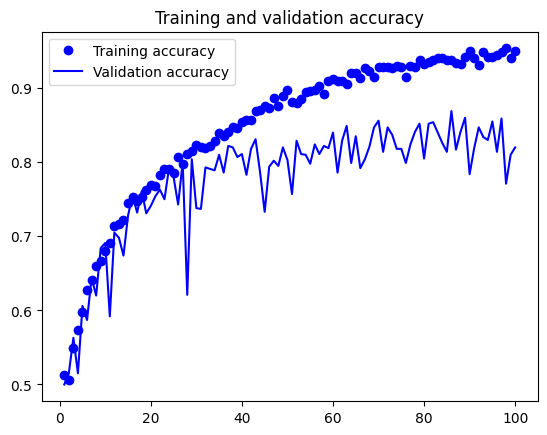

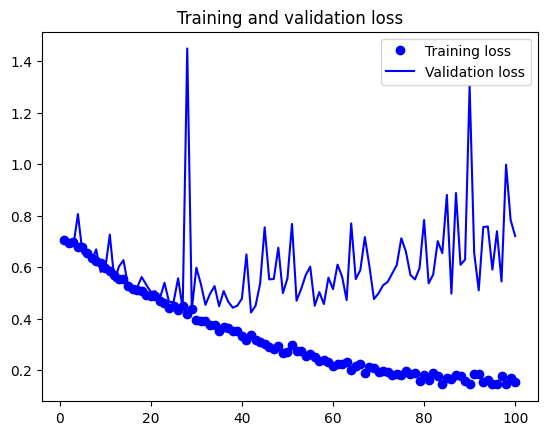

In [29]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [30]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 33ms/step - loss: 0.4526 - accuracy: 0.8205
Test accuracy: 0.821


## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [31]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [32]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [33]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 32ms/step


In [34]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [35]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 10.9639 - accuracy: 0.9285 - val_loss: 9.2315 - val_accuracy: 0.9370
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 3.6276 - accuracy: 0.9760 - val_loss: 3.5767 - val_accuracy: 0.9670
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 2.5031 - accuracy: 0.9855 - val_loss: 11.6391 - val_accuracy: 0.9520
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 1.4005 - accuracy: 0.9890 - val_loss: 5.0422 - val_accuracy: 0.9730
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 1.1688 - accuracy: 0.9910 - val_loss: 6.5640 - val_accuracy: 0.9660
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.6659 - accuracy: 0.9925 - val_loss: 3.9594 - val_accuracy: 0.9740
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.4210 - accuracy: 0.9930 - val_loss: 4.9743 - val_accuracy: 0.9780
Epoch 8/20
63/63 [

**Plotting the results**

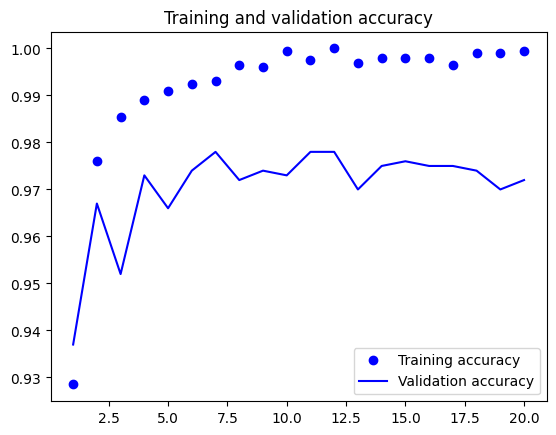

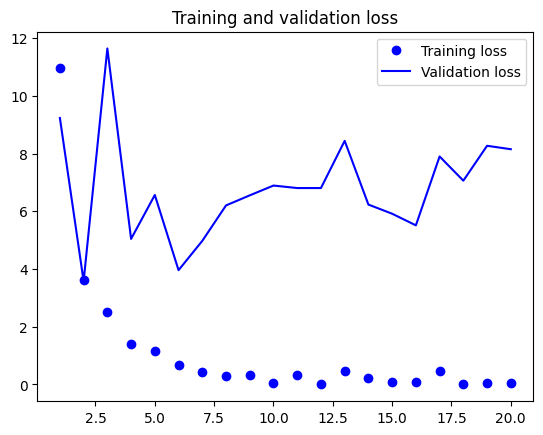

In [36]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [37]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [38]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [39]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [40]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [41]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 12s 154ms/step - loss: 21.6546 - accuracy: 0.8915 - val_loss: 5.0872 - val_accuracy: 0.9570
Epoch 2/50
63/63 [==============================] - 10s 153ms/step - loss: 7.1406 - accuracy: 0.9430 - val_loss: 5.2083 - val_accuracy: 0.9660
Epoch 3/50
63/63 [==============================] - 10s 159ms/step - loss: 4.6903 - accuracy: 0.9560 - val_loss: 6.6635 - val_accuracy: 0.9640
Epoch 4/50
63/63 [==============================] - 10s 153ms/step - loss: 5.6810 - accuracy: 0.9565 - val_loss: 3.5329 - val_accuracy: 0.9730
Epoch 5/50
63/63 [==============================] - 10s 148ms/step - loss: 4.4150 - accuracy: 0.9625 - val_loss: 8.5252 - val_accuracy: 0.9630
Epoch 6/50
63/63 [==============================] - 10s 146ms/step - loss: 4.1042 - accuracy: 0.9645 - val_loss: 5.4195 - val_accuracy: 0.9750
Epoch 7/50
63/63 [==============================] - 9s 146ms/step - loss: 2.5670 - accuracy: 0.9735 - val_loss: 4.0190 - val_accuracy: 0.9760

**Evaluating the model on the test set**

In [42]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 93ms/step - loss: 2.1032 - accuracy: 0.9780
Test accuracy: 0.978


### Fine-tuning a pretrained model

In [43]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [44]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [45]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 13s 174ms/step - loss: 0.2142 - accuracy: 0.9930 - val_loss: 2.1543 - val_accuracy: 0.9800
Epoch 2/30
63/63 [==============================] - 11s 170ms/step - loss: 0.3584 - accuracy: 0.9875 - val_loss: 1.9283 - val_accuracy: 0.9740
Epoch 3/30
63/63 [==============================] - 11s 173ms/step - loss: 0.2826 - accuracy: 0.9895 - val_loss: 1.9231 - val_accuracy: 0.9740
Epoch 4/30
63/63 [==============================] - 11s 170ms/step - loss: 0.4753 - accuracy: 0.9885 - val_loss: 1.7846 - val_accuracy: 0.9790
Epoch 5/30
63/63 [==============================] - 11s 168ms/step - loss: 0.3662 - accuracy: 0.9880 - val_loss: 1.4248 - val_accuracy: 0.9790
Epoch 6/30
63/63 [==============================] - 11s 163ms/step - loss: 0.2607 - accuracy: 0.9935 - val_loss: 1.4746 - val_accuracy: 0.9790
Epoch 7/30
63/63 [==============================] - 11s 164ms/step - loss: 0.2684 - accuracy: 0.9935 - val_loss: 1.5549 - val_accuracy: 0.9800

In [46]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 93ms/step - loss: 1.3713 - accuracy: 0.9800
Test accuracy: 0.980


## Summary

* Convnets are the best type of machine learning models for computer vision
tasks. It’s possible to train one from scratch even on a very small dataset, with
decent results.
* Convnets work by learning a hierarchy of modular patterns and concepts to
represent the visual world.
* On a small dataset, overfitting will be the main issue. Data augmentation is a
powerful way to fight overfitting when you’re working with image data.
* It’s easy to reuse an existing convnet on a new dataset via feature extraction.
This is a valuable technique for working with small image datasets.
* As a complement to feature extraction, you can use fine-tuning, which adapts to
a new problem some of the representations previously learned by an existing
model. This pushes performance a bit further.